# Conventional PINNs

In [1]:
#Import packages
using OrdinaryDiffEq      #Package use to create and solve ODEs.
using NeuralPDE           #Package to create a PINNs.
using Lux                 #Package to create a layer of PINNs.
using OptimizationOptimJL #Package to create a optimazation problems and optimize the loss function. 

### Classical Method

In [2]:
function SMIB(du,u,p,t)             #Define the power system dynamics.
    du[1] = u[2]
    du[2] = 5- 10*sin(u[1])-1.7*u[2]
end;
u0 = [-1.0, 7.0]                    #Initial conditions.
h = 0.01                            #Time steps.
tspan = (0.0,10.0)                  #Duration simulation.
prob = ODEProblem(SMIB,u0,tspan);   #Define the ODEs system which solved by ODE solvers.
sol = solve(prob,Tsit5(),dt = h,adaptive = false);
sol = transpose(sol);               #Using transpose function to plot results and save it to CSV file.

### PINNs Method

In [ ]:
SMIB_NN(u,p,t) = [u[2],5- 10*sin(u[1])-1.7*u[2]] #Define the set of equations of SMIB system.
prob_NN = ODEProblem(SMIB_NN,u0,tspan);          #Create a ODEs system from a set of equations. 

func = Lux.tanh      #Define the activation function from Lux.jl package.
N = 20               #Define the number neurons of hidden layers.

#Create a network.
#Chain: Collects multiple layers / functions to be called in sequence on a given input.
#Dense: Create a traditional fully connected layer, whose forward pass is given by: y = activation.(weight * x .+ bias).
#Reader can visit "https://docs.juliahub.com/Lux/Jbrqh/0.4.24/autodocs/" for more information.
#The output size of a network equals to the length of state variables.

chain = Lux.Chain(Lux.Dense(1, N, func), Lux.Dense(N, N, func), Lux.Dense(N, N, func),
                    Lux.Dense(N, N, func), Lux.Dense(N, length(u0)))

opt = OptimizationOptimJL.BFGS()                                        #Define the optimizer (BFGS).
alg = NeuralPDE.NNODE(chain, opt, autodiff = false)                     #Define the algorithm for training the network.
sol_NN = solve(prob_NN, alg, verbose=false, maxiters = 50000, saveat = 0.01);

In [4]:
chain   #Show the total parameters of networks

Chain(
    layer_1 = Dense(1 => 20, tanh_fast),  # 40 parameters
    layer_2 = Dense(20 => 20, tanh_fast),  # 420 parameters
    layer_3 = Dense(20 => 20, tanh_fast),  # 420 parameters
    layer_4 = Dense(20 => 20, tanh_fast),  # 420 parameters
    layer_5 = Dense(20 => 2),           # 42 parameters
)         # Total: 1_342 parameters,
          #        plus 0 states.

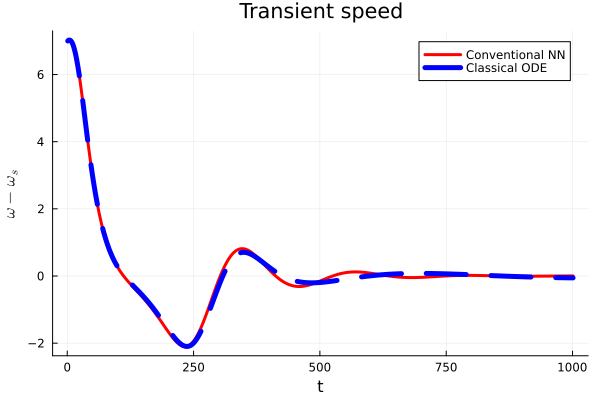

In [7]:
#Plotting the results of transient speed.
using Plots
plot(u_predict[2,:], ls = :solid, lw = 3, label= "Symbolic NN", lc = :red)
plot!(sol[:,2],ls = :dash, lw = 5, label = "Classical ODE", lc = :blue)
title!("Transient speed")
xlabel!("t")
ylabel!("\$ \\omega - \\omega_s \$")

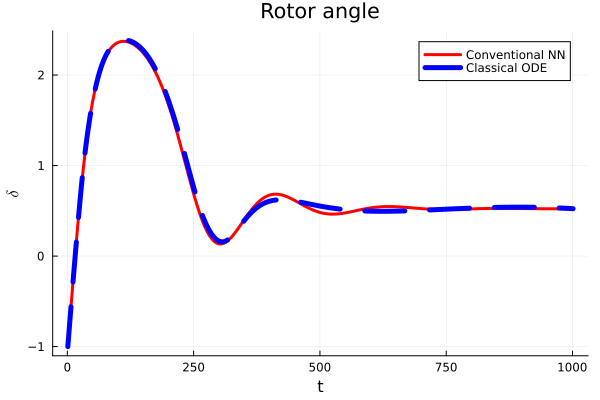

In [8]:
#Plotting the results of rotor angle.
plot(u_predict[1,:], ls = :solid, lw = 3, label= "Conventional NN", lc = :red)
plot!(sol[:,1],ls = :dash, lw = 5, label = "Classical ODE", lc = :blue)
title!("Rotor angle")
xlabel!("t")
ylabel!("\$ \\delta \$")

In [ ]:
using DataFrames
using CSV
df = DataFrame(delta_NN = sol_NN[1,:], omega_NN = sol_NN[2,:], delta_ODE = sol[:,1], omega_ODE=sol[:,2]) #delta = -1, transient = 7
CSV.write("filename.csv", df; append = false) 